In [24]:
import deepchem as dc
import torch
from deepchem.models import GCNModel
import pandas as pd
import numpy as np
import warnings
from tqdm import tqdm
import os
warnings.filterwarnings("ignore")

In [25]:
clean_data = pd.read_csv(r"Data.csv")

In [26]:
data = clean_data

In [27]:
smiles = data.SMILES.to_list()
labels = data.LABELS.to_list()
        
featurizer = dc.feat.MolGraphConvFeaturizer() ## Feature calculator
        
X = featurizer.featurize(smiles)
        
dataset = dc.data.NumpyDataset(X=X, y=labels)
        
torch_data = dataset.make_pytorch_dataset()

In [28]:
from torch_geometric.data import Dataset, Data
from torch_geometric.loader import DataLoader

In [29]:
class BBBDataset(Dataset):
    
    def __init__(self,root,transform=None,pre_transform=None,pre_filter=None):
        
        super().__init__(root, transform, pre_transform, pre_filter)
        
        
        
    @property
    def raw_file_names(self):
        
        """
        If this file exists in raw_dir, the download is not triggered
        """
        return "data.csv"
        
    def download(self):
        pass
    
    @property
    def processed_file_names(self):
        return ['data.pt']
    
    
    def process(self):
        
        self.data = pd.read_csv(self.raw_paths[0])
        smiles = self.data.SMILES.to_list()
        labels = self.data.LABELS.to_list()
        
        featurizer = dc.feat.MolGraphConvFeaturizer() ## Feature calculator
        
        X = featurizer.featurize(smiles)
        
        j=0
        for idx, Gdata in tqdm(enumerate(X)):
            
            pyG_data = Gdata
            
            nodes = torch.tensor(pyG_data.node_features,dtype= torch.float32)
            
            Edge_index = torch.tensor(pyG_data.edge_index,dtype= torch.int64 )
            #Edge_feats = torch.tensor(pyG_data.edge_features,dtype=torch.float32)
            y = torch.tensor([labels[idx]],dtype= torch.float32 )
            ### create data object
            data = Data(x=nodes,edge_index=Edge_index,y=y,smiles=smiles[idx])
            torch.save(data,os.path.join(self.processed_dir,f"data_{j}.pt"))
            j+=1
            
    def len (self):
        return self.data.shape[0]
    
    def get(self,idx):
        data = torch.load(os.path.join(self.processed_dir,f'data_{idx}.pt'))
        return data

    
    

In [30]:
dataset = BBBDataset(root=".",)

Processing...
3330it [00:02, 1426.90it/s]
Done!


In [31]:
from torch.utils.data import random_split
### Splitting of data
train_set, valid_set, test_set = random_split(dataset,[2331,666,333])
trainloader = DataLoader(train_set,shuffle=True,batch_size=256)
validloader = DataLoader(valid_set, shuffle=True,batch_size=256)
testloader = DataLoader(test_set, shuffle=True,batch_size=256)

## Applying PyGCN

In [32]:
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True

In [33]:
from dgl.nn import WeightAndSum
import torch.nn as nn
from torch_geometric.nn import GlobalAttention,GATConv
from torch_geometric.nn import global_add_pool,global_max_pool
from torch.nn import Sequential
import torch.nn.functional as F

In [42]:
from torch_geometric.nn import global_mean_pool


class PyGAT(nn.Module):
    
    def __init__(self,):
        
        super().__init__()
        
        """
        First GAT layer with 3 attention head for each node
        """
        self.GAT_Conv1 = GATConv(in_channels= -1, 
                                 out_channels= 8,
                                 heads = 3,
                                 concat=True)
        
        self.GAT_Conv2 = GATConv(in_channels= 24, 
                                 out_channels= 16,
                                 heads = 1,)
        
        self.GateNN = Sequential(nn.Linear(in_features=(16),out_features=1),)
        
        self.fC_layer = nn.Linear(16,8)
        
        self.GlobalAtt = GlobalAttention(self.GateNN,)
        
        self.fc_1 = nn.Linear(16,1)
                 
    def forward(self,data):
        
        ### Extracting data from batch
        batch, x, edge_index, edge_attr = (data.batch, data.x, data.edge_index, data.edge_attr)
        
        x = F.dropout(x, p=0.5, training=self.training)
        
        x = self.GAT_Conv1(x=x,edge_index=edge_index)
        
        x = F.elu(x)
        
         ##x = F.dropout(x, p=0.5, training=self.training) 
        
        x = self.GAT_Conv2(x,edge_index)
        
        x = global_max_pool(x,batch) ## Changed
        
        #x = self.GlobalAtt(x,batch)
        
        x = F.sigmoid(self.fc_1(x))
        
        return x

In [49]:
from torch.nn import BCEWithLogitsLoss, BCELoss,CrossEntropyLoss, Softmax

## Intilaize Network
net = PyGAT()

### initialize an optimizer with someparameters
optimizer = torch.optim.Adam(net.parameters(), lr=0.001,weight_decay=5e-4)

### Defining loss
criterion = BCELoss()

### criterion
criterion.cuda()

## shifting to GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
net.to(device)

PyGAT(
  (GAT_Conv1): GATConv(-1, 8, heads=3)
  (GAT_Conv2): GATConv(24, 16, heads=1)
  (GateNN): Sequential(
    (0): Linear(in_features=16, out_features=1, bias=True)
  )
  (fC_layer): Linear(in_features=16, out_features=8, bias=True)
  (GlobalAtt): GlobalAttention(gate_nn=Sequential(
    (0): Linear(in_features=16, out_features=1, bias=True)
  ), nn=None)
  (fc_1): Linear(in_features=16, out_features=1, bias=True)
)

In [50]:
from sklearn.metrics import accuracy_score
def accuracy_counter(y_prob,y_true):
    
    y_prob = np.array(y_prob)
    y_prob = np.where(y_prob <= 0.5, 0, y_prob)
    y_prob = np.where(y_prob > 0.5, 1, y_prob)
    accuracy = accuracy_score(np.array(y_true),y_prob)
    
    return (accuracy,)

In [51]:
def train():
    
    net.train()
    y_true = []
    proab = []
    train_loss = []
    for data in trainloader:## Iterate in batches over training dataset
        data.to(device)
        
        optimizer.zero_grad() ## clear gradients
        out = net(data).squeeze(0) ## single forward pass
        
        proab.extend(out.detach().cpu().numpy().squeeze().tolist()) ## appending to list each batch
        y_true.extend(data.y.unsqueeze(1).squeeze().tolist()) ## appending true value of each batch
        
        loss = criterion(out,data.y.unsqueeze(1)) ## compute the loss
        
        train_loss.append(loss)
        
        loss.backward() ## Derive gradients
        optimizer.step()## update parameters based on gradients
        
    av_loss = torch.sum(torch.tensor(train_loss))/len(trainloader)
    
    accuracy = accuracy_counter(proab,y_true)
    
    return (av_loss,accuracy)

In [52]:
@torch.no_grad()
def test(loader):
    net.eval()
    y_true = []
    proab = []
    val_loss = []
    for data in loader:## Iterate in batches over training dataset
        data.to(device)
        out = net(data).squeeze(0) ## single forward pass
        
        proab.extend(out.detach().cpu().numpy().squeeze().tolist()) ## appending to list each batch
        y_true.extend(data.y.unsqueeze(1).squeeze().tolist()) ## appending true value of each batch
    
        loss = criterion(out,data.y.unsqueeze(1))
        val_loss.append(loss)
        
    val = torch.sum(torch.tensor(val_loss))/len(loader)
    accuracy = accuracy_counter(proab,y_true)
    return (val,accuracy)

In [53]:
epochs = 1000

## Accuracy
traine_accuracy = []
vale_accuracy = []
teste_accuracy = []

## Loss
epoch_loss = []
valida_loss = []
test_loss_full = []

for epoch in range(1,epochs):
    
    train_loss1,train_accuracy1 = train()
    
    train_loss2,train_accuracy2 = test(trainloader)
    
    val_loss,val_accuracy = test(validloader)
    
    test_loss,test_accuracy = test(testloader)
    
    ##losses
    epoch_loss.append(train_loss1)
    valida_loss.append(val_loss)
    test_loss_full.append(test_loss)
    
    ## accuracy
    traine_accuracy.append(train_accuracy1[0])
    vale_accuracy.append(val_accuracy[0])
    teste_accuracy.append(test_accuracy[0])
    
    print(f'Epoch: {epoch:03d}, Train loss: {train_loss1:.4f}, Train accuracy: {train_accuracy1[0]:.4f}, val loss: {val_loss:.4f}, val accuracy: {val_accuracy[0]:.4f}')

Epoch: 001, Train loss: 0.6939, Train accuracy: 0.5054, val loss: 0.6728, val accuracy: 0.5961
Epoch: 002, Train loss: 0.6647, Train accuracy: 0.6229, val loss: 0.6707, val accuracy: 0.5931
Epoch: 003, Train loss: 0.6673, Train accuracy: 0.6195, val loss: 0.6710, val accuracy: 0.5931
Epoch: 004, Train loss: 0.6482, Train accuracy: 0.6186, val loss: 0.6755, val accuracy: 0.5931
Epoch: 005, Train loss: 0.6503, Train accuracy: 0.6186, val loss: 0.6662, val accuracy: 0.5931
Epoch: 006, Train loss: 0.6415, Train accuracy: 0.6186, val loss: 0.6643, val accuracy: 0.5931
Epoch: 007, Train loss: 0.6492, Train accuracy: 0.6190, val loss: 0.6692, val accuracy: 0.5916
Epoch: 008, Train loss: 0.6342, Train accuracy: 0.6233, val loss: 0.6653, val accuracy: 0.5901
Epoch: 009, Train loss: 0.6522, Train accuracy: 0.6242, val loss: 0.6622, val accuracy: 0.5901
Epoch: 010, Train loss: 0.6396, Train accuracy: 0.6268, val loss: 0.6613, val accuracy: 0.5946
Epoch: 011, Train loss: 0.6370, Train accuracy: 0.

Epoch: 088, Train loss: 0.5407, Train accuracy: 0.7246, val loss: 0.6624, val accuracy: 0.6306
Epoch: 089, Train loss: 0.5489, Train accuracy: 0.7207, val loss: 0.6488, val accuracy: 0.6411
Epoch: 090, Train loss: 0.5634, Train accuracy: 0.7109, val loss: 0.6459, val accuracy: 0.6562
Epoch: 091, Train loss: 0.5455, Train accuracy: 0.7259, val loss: 0.6428, val accuracy: 0.6486
Epoch: 092, Train loss: 0.5757, Train accuracy: 0.7134, val loss: 0.6458, val accuracy: 0.6547
Epoch: 093, Train loss: 0.5501, Train accuracy: 0.7254, val loss: 0.6597, val accuracy: 0.6517
Epoch: 094, Train loss: 0.5494, Train accuracy: 0.7104, val loss: 0.6575, val accuracy: 0.6471
Epoch: 095, Train loss: 0.5646, Train accuracy: 0.7177, val loss: 0.6443, val accuracy: 0.6547
Epoch: 096, Train loss: 0.5531, Train accuracy: 0.7224, val loss: 0.6533, val accuracy: 0.6547
Epoch: 097, Train loss: 0.5570, Train accuracy: 0.7164, val loss: 0.6638, val accuracy: 0.6502
Epoch: 098, Train loss: 0.5745, Train accuracy: 0.

Epoch: 175, Train loss: 0.5549, Train accuracy: 0.7233, val loss: 0.6599, val accuracy: 0.6592
Epoch: 176, Train loss: 0.5468, Train accuracy: 0.7139, val loss: 0.6571, val accuracy: 0.6622
Epoch: 177, Train loss: 0.5570, Train accuracy: 0.7259, val loss: 0.6652, val accuracy: 0.6517
Epoch: 178, Train loss: 0.5481, Train accuracy: 0.7323, val loss: 0.6579, val accuracy: 0.6547
Epoch: 179, Train loss: 0.5428, Train accuracy: 0.7242, val loss: 0.6482, val accuracy: 0.6592
Epoch: 180, Train loss: 0.5509, Train accuracy: 0.7263, val loss: 0.6745, val accuracy: 0.6502
Epoch: 181, Train loss: 0.5377, Train accuracy: 0.7314, val loss: 0.6653, val accuracy: 0.6562
Epoch: 182, Train loss: 0.5505, Train accuracy: 0.7246, val loss: 0.6410, val accuracy: 0.6577
Epoch: 183, Train loss: 0.5247, Train accuracy: 0.7302, val loss: 0.6599, val accuracy: 0.6562
Epoch: 184, Train loss: 0.5467, Train accuracy: 0.7353, val loss: 0.6509, val accuracy: 0.6592
Epoch: 185, Train loss: 0.5531, Train accuracy: 0.

Epoch: 262, Train loss: 0.5482, Train accuracy: 0.7409, val loss: 0.6550, val accuracy: 0.6577
Epoch: 263, Train loss: 0.5443, Train accuracy: 0.7379, val loss: 0.6615, val accuracy: 0.6577
Epoch: 264, Train loss: 0.5445, Train accuracy: 0.7237, val loss: 0.6629, val accuracy: 0.6562
Epoch: 265, Train loss: 0.5312, Train accuracy: 0.7297, val loss: 0.6729, val accuracy: 0.6517
Epoch: 266, Train loss: 0.5208, Train accuracy: 0.7383, val loss: 0.6711, val accuracy: 0.6562
Epoch: 267, Train loss: 0.5357, Train accuracy: 0.7314, val loss: 0.6676, val accuracy: 0.6577
Epoch: 268, Train loss: 0.5385, Train accuracy: 0.7314, val loss: 0.6550, val accuracy: 0.6592
Epoch: 269, Train loss: 0.5329, Train accuracy: 0.7443, val loss: 0.6556, val accuracy: 0.6592
Epoch: 270, Train loss: 0.5406, Train accuracy: 0.7319, val loss: 0.6846, val accuracy: 0.6471
Epoch: 271, Train loss: 0.5319, Train accuracy: 0.7344, val loss: 0.6386, val accuracy: 0.6547
Epoch: 272, Train loss: 0.5352, Train accuracy: 0.

Epoch: 349, Train loss: 0.5134, Train accuracy: 0.7456, val loss: 0.6604, val accuracy: 0.6562
Epoch: 350, Train loss: 0.5191, Train accuracy: 0.7353, val loss: 0.6705, val accuracy: 0.6562
Epoch: 351, Train loss: 0.5615, Train accuracy: 0.7272, val loss: 0.6514, val accuracy: 0.6562
Epoch: 352, Train loss: 0.5361, Train accuracy: 0.7267, val loss: 0.6523, val accuracy: 0.6562
Epoch: 353, Train loss: 0.5395, Train accuracy: 0.7353, val loss: 0.6815, val accuracy: 0.6486
Epoch: 354, Train loss: 0.5235, Train accuracy: 0.7417, val loss: 0.6546, val accuracy: 0.6547
Epoch: 355, Train loss: 0.5399, Train accuracy: 0.7276, val loss: 0.6659, val accuracy: 0.6562
Epoch: 356, Train loss: 0.5206, Train accuracy: 0.7340, val loss: 0.6821, val accuracy: 0.6486
Epoch: 357, Train loss: 0.5255, Train accuracy: 0.7327, val loss: 0.6637, val accuracy: 0.6547
Epoch: 358, Train loss: 0.5358, Train accuracy: 0.7344, val loss: 0.6808, val accuracy: 0.6502
Epoch: 359, Train loss: 0.5247, Train accuracy: 0.

Epoch: 436, Train loss: 0.5209, Train accuracy: 0.7452, val loss: 0.6568, val accuracy: 0.6532
Epoch: 437, Train loss: 0.5313, Train accuracy: 0.7336, val loss: 0.6813, val accuracy: 0.6471
Epoch: 438, Train loss: 0.5136, Train accuracy: 0.7435, val loss: 0.6597, val accuracy: 0.6547
Epoch: 439, Train loss: 0.5353, Train accuracy: 0.7422, val loss: 0.6683, val accuracy: 0.6562
Epoch: 440, Train loss: 0.5206, Train accuracy: 0.7430, val loss: 0.6604, val accuracy: 0.6532
Epoch: 441, Train loss: 0.5398, Train accuracy: 0.7396, val loss: 0.6636, val accuracy: 0.6532
Epoch: 442, Train loss: 0.5280, Train accuracy: 0.7344, val loss: 0.6695, val accuracy: 0.6502
Epoch: 443, Train loss: 0.5347, Train accuracy: 0.7379, val loss: 0.6606, val accuracy: 0.6502
Epoch: 444, Train loss: 0.5130, Train accuracy: 0.7413, val loss: 0.6488, val accuracy: 0.6592
Epoch: 445, Train loss: 0.5087, Train accuracy: 0.7362, val loss: 0.6856, val accuracy: 0.6532
Epoch: 446, Train loss: 0.5146, Train accuracy: 0.

Epoch: 523, Train loss: 0.5298, Train accuracy: 0.7456, val loss: 0.6439, val accuracy: 0.6622
Epoch: 524, Train loss: 0.5179, Train accuracy: 0.7447, val loss: 0.6705, val accuracy: 0.6547
Epoch: 525, Train loss: 0.5233, Train accuracy: 0.7465, val loss: 0.6591, val accuracy: 0.6547
Epoch: 526, Train loss: 0.5263, Train accuracy: 0.7486, val loss: 0.6650, val accuracy: 0.6517
Epoch: 527, Train loss: 0.5356, Train accuracy: 0.7383, val loss: 0.6617, val accuracy: 0.6562
Epoch: 528, Train loss: 0.4968, Train accuracy: 0.7340, val loss: 0.6731, val accuracy: 0.6532
Epoch: 529, Train loss: 0.5336, Train accuracy: 0.7452, val loss: 0.6686, val accuracy: 0.6547
Epoch: 530, Train loss: 0.5224, Train accuracy: 0.7396, val loss: 0.6500, val accuracy: 0.6577
Epoch: 531, Train loss: 0.5298, Train accuracy: 0.7516, val loss: 0.6587, val accuracy: 0.6532
Epoch: 532, Train loss: 0.5207, Train accuracy: 0.7456, val loss: 0.6476, val accuracy: 0.6562
Epoch: 533, Train loss: 0.5329, Train accuracy: 0.

Epoch: 610, Train loss: 0.5234, Train accuracy: 0.7490, val loss: 0.6711, val accuracy: 0.6486
Epoch: 611, Train loss: 0.5374, Train accuracy: 0.7405, val loss: 0.6637, val accuracy: 0.6517
Epoch: 612, Train loss: 0.5251, Train accuracy: 0.7443, val loss: 0.6735, val accuracy: 0.6517
Epoch: 613, Train loss: 0.5384, Train accuracy: 0.7400, val loss: 0.6781, val accuracy: 0.6486
Epoch: 614, Train loss: 0.5360, Train accuracy: 0.7284, val loss: 0.6540, val accuracy: 0.6547
Epoch: 615, Train loss: 0.5214, Train accuracy: 0.7435, val loss: 0.6650, val accuracy: 0.6517
Epoch: 616, Train loss: 0.5069, Train accuracy: 0.7580, val loss: 0.6624, val accuracy: 0.6607
Epoch: 617, Train loss: 0.5313, Train accuracy: 0.7422, val loss: 0.6436, val accuracy: 0.6652
Epoch: 618, Train loss: 0.5293, Train accuracy: 0.7499, val loss: 0.6613, val accuracy: 0.6562
Epoch: 619, Train loss: 0.5176, Train accuracy: 0.7340, val loss: 0.6898, val accuracy: 0.6321
Epoch: 620, Train loss: 0.5222, Train accuracy: 0.

Epoch: 697, Train loss: 0.5238, Train accuracy: 0.7452, val loss: 0.6457, val accuracy: 0.6532
Epoch: 698, Train loss: 0.5220, Train accuracy: 0.7370, val loss: 0.6885, val accuracy: 0.6351
Epoch: 699, Train loss: 0.5079, Train accuracy: 0.7375, val loss: 0.6589, val accuracy: 0.6532
Epoch: 700, Train loss: 0.5078, Train accuracy: 0.7413, val loss: 0.6656, val accuracy: 0.6532
Epoch: 701, Train loss: 0.5249, Train accuracy: 0.7332, val loss: 0.6720, val accuracy: 0.6517
Epoch: 702, Train loss: 0.5254, Train accuracy: 0.7417, val loss: 0.6635, val accuracy: 0.6517
Epoch: 703, Train loss: 0.5131, Train accuracy: 0.7460, val loss: 0.6634, val accuracy: 0.6532
Epoch: 704, Train loss: 0.5353, Train accuracy: 0.7344, val loss: 0.6807, val accuracy: 0.6517
Epoch: 705, Train loss: 0.5122, Train accuracy: 0.7426, val loss: 0.6757, val accuracy: 0.6517
Epoch: 706, Train loss: 0.5106, Train accuracy: 0.7435, val loss: 0.6925, val accuracy: 0.6517
Epoch: 707, Train loss: 0.5149, Train accuracy: 0.

Epoch: 784, Train loss: 0.5121, Train accuracy: 0.7409, val loss: 0.6781, val accuracy: 0.6366
Epoch: 785, Train loss: 0.5153, Train accuracy: 0.7409, val loss: 0.6822, val accuracy: 0.6426
Epoch: 786, Train loss: 0.5197, Train accuracy: 0.7503, val loss: 0.6965, val accuracy: 0.6366
Epoch: 787, Train loss: 0.5058, Train accuracy: 0.7443, val loss: 0.6694, val accuracy: 0.6622
Epoch: 788, Train loss: 0.5256, Train accuracy: 0.7452, val loss: 0.6522, val accuracy: 0.6607
Epoch: 789, Train loss: 0.5102, Train accuracy: 0.7538, val loss: 0.6677, val accuracy: 0.6592
Epoch: 790, Train loss: 0.5134, Train accuracy: 0.7538, val loss: 0.6764, val accuracy: 0.6547
Epoch: 791, Train loss: 0.5132, Train accuracy: 0.7409, val loss: 0.6734, val accuracy: 0.6607
Epoch: 792, Train loss: 0.4984, Train accuracy: 0.7413, val loss: 0.6996, val accuracy: 0.6321
Epoch: 793, Train loss: 0.5041, Train accuracy: 0.7465, val loss: 0.6643, val accuracy: 0.6622
Epoch: 794, Train loss: 0.5154, Train accuracy: 0.

Epoch: 871, Train loss: 0.5065, Train accuracy: 0.7400, val loss: 0.6847, val accuracy: 0.6562
Epoch: 872, Train loss: 0.5359, Train accuracy: 0.7392, val loss: 0.6900, val accuracy: 0.6502
Epoch: 873, Train loss: 0.5121, Train accuracy: 0.7443, val loss: 0.6588, val accuracy: 0.6532
Epoch: 874, Train loss: 0.5117, Train accuracy: 0.7576, val loss: 0.6758, val accuracy: 0.6547
Epoch: 875, Train loss: 0.5071, Train accuracy: 0.7452, val loss: 0.6500, val accuracy: 0.6667
Epoch: 876, Train loss: 0.5116, Train accuracy: 0.7550, val loss: 0.6686, val accuracy: 0.6547
Epoch: 877, Train loss: 0.5288, Train accuracy: 0.7473, val loss: 0.6621, val accuracy: 0.6652
Epoch: 878, Train loss: 0.5248, Train accuracy: 0.7516, val loss: 0.6675, val accuracy: 0.6547
Epoch: 879, Train loss: 0.5112, Train accuracy: 0.7495, val loss: 0.6544, val accuracy: 0.6577
Epoch: 880, Train loss: 0.4964, Train accuracy: 0.7439, val loss: 0.6635, val accuracy: 0.6577
Epoch: 881, Train loss: 0.5056, Train accuracy: 0.

Epoch: 958, Train loss: 0.5083, Train accuracy: 0.7443, val loss: 0.6771, val accuracy: 0.6517
Epoch: 959, Train loss: 0.5066, Train accuracy: 0.7387, val loss: 0.6397, val accuracy: 0.6697
Epoch: 960, Train loss: 0.5063, Train accuracy: 0.7482, val loss: 0.6463, val accuracy: 0.6667
Epoch: 961, Train loss: 0.5149, Train accuracy: 0.7465, val loss: 0.6570, val accuracy: 0.6667
Epoch: 962, Train loss: 0.5256, Train accuracy: 0.7550, val loss: 0.6267, val accuracy: 0.6697
Epoch: 963, Train loss: 0.5136, Train accuracy: 0.7426, val loss: 0.6621, val accuracy: 0.6592
Epoch: 964, Train loss: 0.5033, Train accuracy: 0.7576, val loss: 0.6570, val accuracy: 0.6592
Epoch: 965, Train loss: 0.5035, Train accuracy: 0.7465, val loss: 0.6561, val accuracy: 0.6577
Epoch: 966, Train loss: 0.5028, Train accuracy: 0.7456, val loss: 0.6671, val accuracy: 0.6562
Epoch: 967, Train loss: 0.5195, Train accuracy: 0.7516, val loss: 0.6538, val accuracy: 0.6607
Epoch: 968, Train loss: 0.5136, Train accuracy: 0.

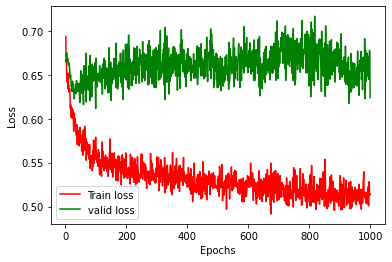

In [57]:
import matplotlib.pyplot as plt

plt.plot([i for i in range(1,epochs)],[i.cpu().detach().numpy() for i  in epoch_loss],label="Train loss",color="Red",)
plt.plot([i for i in range(1,epochs)],[i.cpu().detach().numpy() for i in valida_loss],label="valid loss",color="Green")
#plt.plot([i for i in range(1,epochs)],[i.cpu().detach().numpy() for i in test_loss],label="Test loss",color="Blue")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

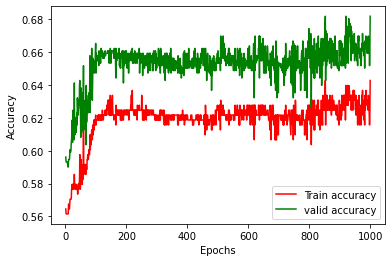

In [58]:
plt.plot([i for i in range(1,epochs)],[i for i  in teste_accuracy],label="Train accuracy",color="Red",)
plt.plot([i for i in range(1,epochs)],[i  for i in vale_accuracy],label="valid accuracy",color="Green")
#plt.plot([i for i in range(1,epochs)],[i.cpu().detach().numpy() for i in test_loss],label="Test loss",color="Blue")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()


### Saving Model

In [188]:
torch.save(net,"model-GCN")

In [189]:
model1 = torch.load("model-GCN")

In [187]:
model1.eval()
model1.to("cpu")
model1([*testloader][4])

tensor([[0.4506]], grad_fn=<SigmoidBackward0>)